## AutoEncoderモデルによるノイズ除去（お試し）

In [1]:
"""
 AutoEncoderモデルによるノイズ除去
"""
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
import seaborn as sns
import os
import copy
import time
from PIL import Image
from sklearn.model_selection import train_test_split
import tqdm as tqdm
import random
#matplotlib inline

e:\Tomonari\PycharmProjects\DL_Models\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## モデルの構築

In [54]:

class ConvDenoiser(nn.Module):
    def __init__(self):
        super(ConvDenoiser, self).__init__()
        ## encoder layers ##
        # conv layer (depth from 1 --> 32), 3x3 kernels
        self.conv1 = nn.Conv2d(1, 512, 3, padding=1)  
        # conv layer (depth from 32 --> 16), 3x3 kernels
        self.conv2 = nn.Conv2d(512, 256, 3, padding=1)
        # conv layer (depth from 16 --> 8), 3x3 kernels
        self.conv3 = nn.Conv2d(256, 128, 3, padding=1)
        # pooling layer to reduce x-y dims by two; kernel and stride of 2
        self.pool = nn.MaxPool2d(2)
        
        ## decoder layers ##
        # transpose layer, a kernel of 2 and a stride of 2 will increase the spatial dims by 2
        self.t_conv1 = nn.ConvTranspose2d(128, 128, 3, stride=2)  # kernel_size=3 to get to a 7x7 image output
        # two more transpose layers with a kernel of 2
        self.t_conv2 = nn.ConvTranspose2d(128, 256, 2, stride=2)
        self.t_conv3 = nn.ConvTranspose2d(256, 512, 2, stride=2)
        # one, final, normal conv layer to decrease the depth
        self.conv_out = nn.Conv2d(512, 1, 3, padding=1)


    def forward(self, x):
        ## encode ##
        # add hidden layers with relu activation function
        # and maxpooling after
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        # add second hidden layer
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        # add third hidden layer
        x = F.relu(self.conv3(x))
        x = self.pool(x)  # compressed representation

        ## decode ##
        # add transpose conv layers, with relu activation function
        x = F.relu(self.t_conv1(x))
        x = F.relu(self.t_conv2(x))
        x = F.relu(self.t_conv3(x))
        
        # transpose again, output should have a sigmoid applied
        x = F.sigmoid(self.conv_out(x))
                
        return x


## データセットの定義

In [3]:
# 作業フォルダの移動
%cd C:\Users\tomonari\Documents\SONY_DICE\Data\AE

C:\Users\tomonari\Documents\SONY_DICE\Data\AE


In [4]:
#datasetクラスの設定
transform = transforms.Compose([
    transforms.ToTensor()
])

class MyDataset(Dataset):
    def __init__(self, image_name_list, phase=None, train_dir="./train/", transform=transform):
        self.image_name_list = image_name_list
        self.phase = phase
        self.train_dir = train_dir
        self.transform = transform
        
    def __len__(self):
        return len(self.image_name_list)
    
    def __getitem__(self, index):
        #index番目の画像を読み込み、前処理を行う
        image_path = self.image_name_list[index]
        image = Image.open(self.train_dir + str(image_path))
        
        if self.transform:
            image = self.transform(image)

        #入力データを返す
        return image

In [5]:
# ディレクトリの指定
TRAIN_DIR = "./train/"
VAL_DIR = "./val/"
TEST_DIR = "./test/"

# パラメータ指定
BATCH_SIZE = 16

# デバイスの指定（CUDA）
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using {device} device")

x_train = os.listdir(TRAIN_DIR)
x_val = os.listdir(VAL_DIR)

datasets = {
    "train" : MyDataset(x_train, phase="train", train_dir=TRAIN_DIR, transform=transform),
    "val" : MyDataset(x_val, phase="val", train_dir=VAL_DIR, transform=transform)
}

dataloaders = {
    'train': DataLoader(datasets['train'], batch_size=BATCH_SIZE, shuffle=True, drop_last=True),
    'val': DataLoader(datasets['val'], batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
 }

Using cuda device


torch.Size([1, 20, 20]) torch.float32 <class 'torch.Tensor'> 466


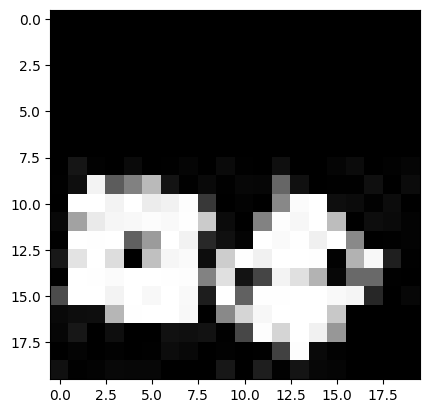

In [6]:
# datasetsの中身の出力
img = datasets["train"][2]
print(img.shape, img.dtype, type(img), len(datasets["train"]))
plt.imshow(img.permute(1,2,0), cmap = "gray")


torch.Size([16, 1, 20, 20]) <class 'torch.Tensor'> 29


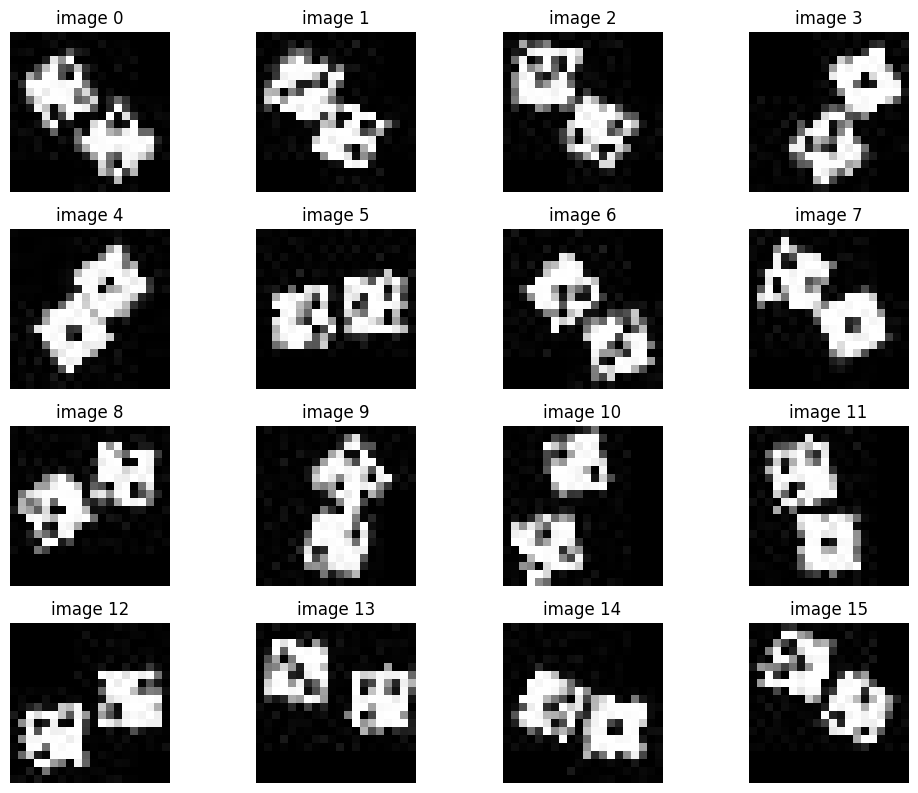

In [7]:
# dataloadersの中身の出力
tmp = dataloaders["train"].__iter__()
batch1 = tmp.__next__()

print(batch1.shape, type(batch1),len(dataloaders["train"]))

plt.figure(figsize=(10, 10))

for i in range(batch1.shape[0]):
    plt.subplot(batch1.shape[0] // 4 + 1, 4, i + 1)
    plt.title(f"image {i}")
    plt.axis("off")
    plt.imshow(batch1[i, :, :, :].numpy().transpose(2, 1, 0), cmap="gray")

plt.tight_layout()

In [8]:
# 画像のチャンネル数、縦のピクセル数、横のピクセル数
input_channels, input_height, input_width = 1, 20, 20  # 20x20の1チャンネル画像の場合

# モデルのインスタンス化
model = ConvDenoiser()

# 入力画像に合わせてダミーのTensorを作成し、モデルに適用して出力サイズを確認
dummy_input = torch.randn(1, input_channels, input_height, input_width)
output = model(dummy_input)
print(output.size())

torch.Size([1, 1, 24, 24])


e:\Tomonari\PycharmProjects\DL_Models\venv\lib\site-packages\torch\nn\functional.py:1967: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


## 学習

In [9]:
# ノイズ印加用関数
def noise(img):
    mean = 0
    sigma = 0.25
    sigma = random.uniform(0, sigma)
    noise = np.random.normal(0, sigma, np.shape(img)).astype(np.float32)
    
    img_noise = img + noise

    img_noise[img_noise > 1] = 1
    img_noise[img_noise < 0] = 0
    
    return img_noise

In [55]:
model = ConvDenoiser()
model.to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9, weight_decay=0.0001)

n_epochs = 300

In [56]:
for epoch in range(1, n_epochs+1):
    # monitor training loss
    train_loss = 0.0
    
    ###################
    # train the model #
    ###################
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        for data in dataloaders[phase]:
            # _ stands in for labels, here
            # no need to flatten images
            images = data
                
            ## add random noise to the input images
            noisy_imgs = noise(images)
            
            # Convert the input tensor to the same data type as the bias tensor
            images = images.to(device)
            noisy_imgs = noisy_imgs.to(device)
                        
            # clear the gradients of all optimized variables
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(noisy_imgs)
                # calculate the loss
                # the "target" is still the original, not-noisy images
                loss = criterion(outputs, images)
                if phase == 'train':
                    # backward pass: compute gradient of the loss with respect to model parameters
                    loss.backward()
                    # perform a single optimization step (parameter update)
                    optimizer.step()
                    # update running training loss
                    train_loss += loss.item()*images.size(0)
                        
        # print avg training statistics 
        train_loss = train_loss/len(dataloaders[phase])
        print(f'Epoch: {epoch} \t{phase} Loss: {train_loss}')

Epoch: 1 	train Loss: 2.1970948268627297
Epoch: 1 	val Loss: 0.24412164742919218
Epoch: 2 	train Loss: 1.5341913289037243
Epoch: 2 	val Loss: 0.17046570321152493
Epoch: 3 	train Loss: 0.8952059314168733
Epoch: 3 	val Loss: 0.09946732571298593
Epoch: 4 	train Loss: 0.7620349958025175
Epoch: 4 	val Loss: 0.08467055508916861
Epoch: 5 	train Loss: 0.7210710418635401
Epoch: 5 	val Loss: 0.08011900465150446
Epoch: 6 	train Loss: 0.6975513717223858
Epoch: 6 	val Loss: 0.07750570796915397
Epoch: 7 	train Loss: 0.6726334300534479
Epoch: 7 	val Loss: 0.07473704778371643
Epoch: 8 	train Loss: 0.6701314099903765
Epoch: 8 	val Loss: 0.07445904555448628
Epoch: 9 	train Loss: 0.6578397319234651
Epoch: 9 	val Loss: 0.07309330354705168
Epoch: 10 	train Loss: 0.6462450109679123
Epoch: 10 	val Loss: 0.07180500121865692
Epoch: 11 	train Loss: 0.6366486734357374
Epoch: 11 	val Loss: 0.0707387414928597
Epoch: 12 	train Loss: 0.6295529521744827
Epoch: 12 	val Loss: 0.06995032801938697
Epoch: 13 	train Loss: 

## 結果の描画

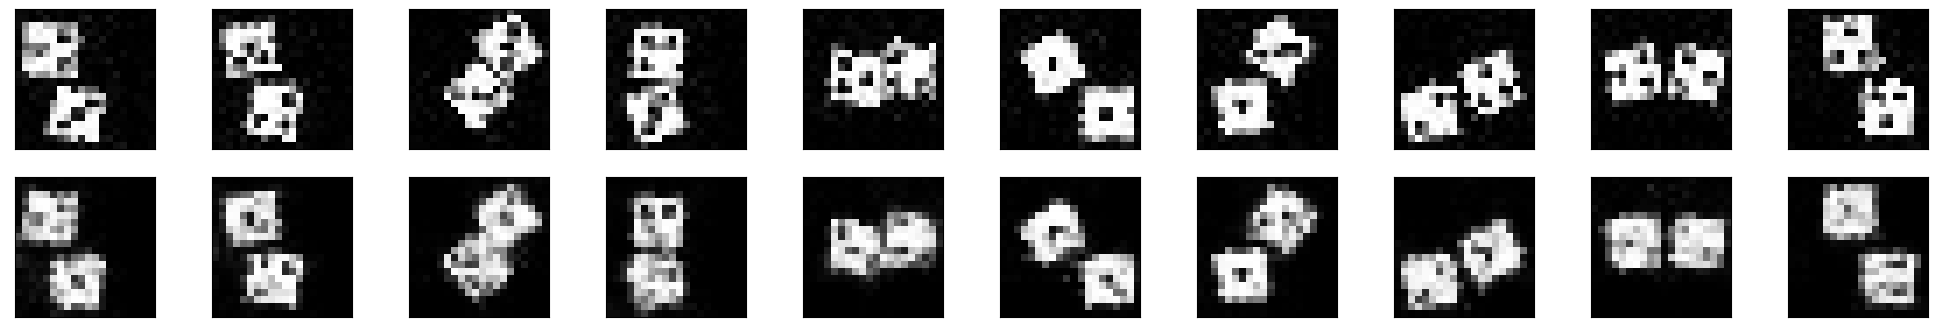

In [58]:
# obtain one batch of test images
tmp = dataloaders["val"].__iter__()
batch = tmp.__next__()

# add noise to the test images
noisy_imgs = noise(batch).to(device)

# get sample outputs
output = model(noisy_imgs)
# prep images for display
noisy_imgs = noisy_imgs.cpu().numpy()

# output is resized into a batch of iages
output = output.view(BATCH_SIZE, 1, 20, 20)
# use detach when it's an output that requires_grad
output = output.detach().cpu().numpy()

# plot the first ten input images and then reconstructed images
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(25,4))

# input images on top row, reconstructions on bottom
for noisy_imgs, row in zip([noisy_imgs, output], axes):
    for img, ax in zip(noisy_imgs, row):
        ax.imshow(np.squeeze(img), cmap='gray')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)